# STM Transit Delay Data Modeling

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('../data/preprocessed.csv')

## Split the data

In [3]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## First Model: Random Forest Regression

### Find optimal number of trees

In [ ]:
# Initialize model with warm start to allow adding more trees without resetting
rf = RandomForestRegressor(
  n_estimators=10,
  warm_start=True,
  random_state=42,
  n_jobs=-1
)

In [9]:
# Combine warm start with manual early stopping
errors = []
n_estimators_range = range(10, 720, 20)
best_rmse = float('inf')
best_n = 10

for n in n_estimators_range:
    rf.n_estimators = n
    rf.fit(X_train, y_train)  # keep training, adding 20 more trees each time
    preds = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    errors.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_n = n

print(f'Best number of trees: {best_n} with RMSE: {best_rmse:.4f}')

Best number of trees: 650 with RMSE: 102.9872


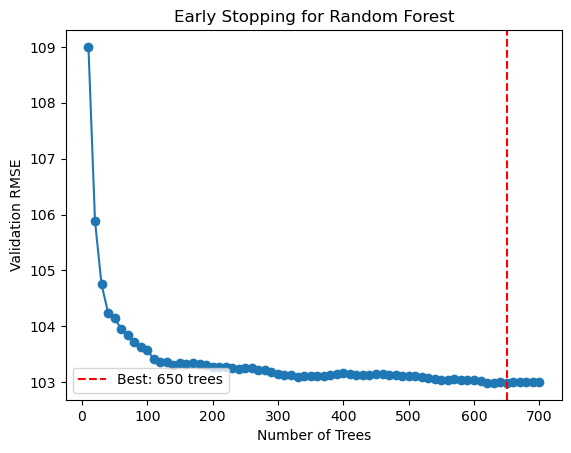

In [10]:
# Plot the curve
plt.plot(n_estimators_range, errors, marker='o')
plt.axvline(x=best_n, color='r', linestyle='--', label=f'Best: {best_n} trees')
plt.xlabel('Number of Trees')
plt.ylabel('Validation RMSE')
plt.title('Early Stopping for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/early_stopping_rf.png')
plt.show()

### Fit Base Model

In [11]:
# Use optimal number of trees
rf_base = RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)

RandomForestRegressor(n_estimators=650, random_state=42)

### Evaluate Model

#### Metrics

In [65]:
y_pred = rf_base.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Create dataframe to track metrics
metrics = [{'model': 'rf_base', 'mae': mae, 'rmse': rmse, 'R²': r2,}]
metrics_df = pd.DataFrame(metrics)
metrics_df

NameError: name 'rf_base' is not defined

**MAE**<br>
On average, the predictions are off by one minute, which seems reasonable.

**RMSE**<br>
The typical error being about 2 minutes seems pretty good.

**R²**<br>
The model explains 48% of the variance in the actual delays, which is not too bad, considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

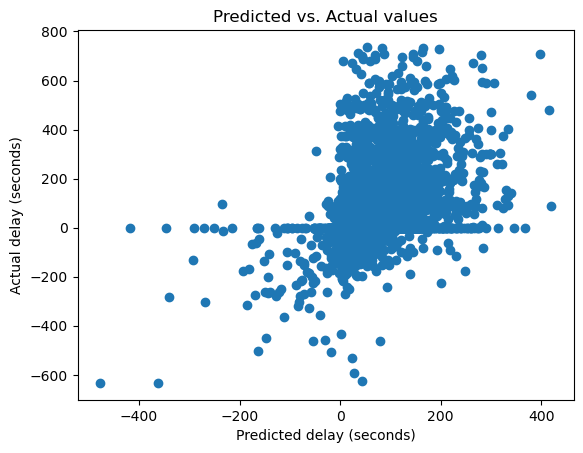

In [14]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/actual_vs_predict_rf_base.png', bbox_inches='tight')
plt.show()

Interpret plot

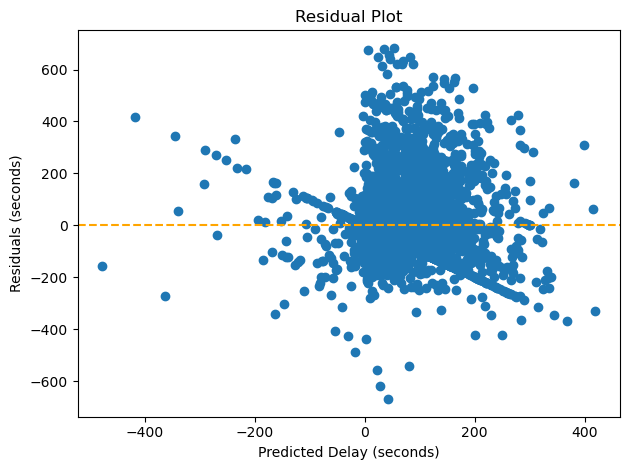

In [15]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/residual_plot_rf_base.png', bbox_inches='tight')
plt.show()

Interpret plot

### Hyperparameter tuning

Due to the large volume of data, a Randomized Search will be run instead of a Grid Search to save computation time.

In [19]:
# Randomized search with 5-Fold Cross Validation
param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  estimator=RandomForestRegressor(n_estimators=best_n, random_state=42),
  param_distributions=param_grid,
  scoring='neg_root_mean_squared_error',
  n_iter=10,
  cv=5,
  n_jobs=-1,
  random_state=42
)

random_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=650,
                                                   random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'max_leaf_nodes': [None, 50, 100],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [20]:
# Fit model with best parameters
best_params = random_model.best_params_

rf_tuned = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.8, min_samples_leaf=5,
                      n_estimators=650, n_jobs=-1, random_state=42)

In [21]:
# Evaluate model
y_pred = rf_tuned.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_tuned', mae, rmse, r2]
metrics_df

MAE: 61.99
RMSE: 102.29
R²: 0.2167


Interpret results

### Feature Importances

In [22]:
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [23]:
# Sort predictors
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

stop_sequence           0.123095
vehicle_id              0.114076
stop_lat                0.091874
sch_hour_sin            0.090115
stop_lon                0.088251
trip_progress           0.087840
route_id                0.084135
stop_id                 0.082994
hour_sin                0.053138
sch_hour_cos            0.038445
hour_cos                0.033840
windspeed               0.030908
temperature             0.028069
occupancy_status        0.026256
is_peak_hour            0.011628
incident_nearby         0.002357
wheelchair_boarding     0.002210
sch_day_cos             0.002037
day_cos                 0.001983
weather_Overcast        0.001935
sch_day_sin             0.001899
day_sin                 0.001627
weather_Mainly clear    0.000825
is_weekend              0.000462
dtype: float64

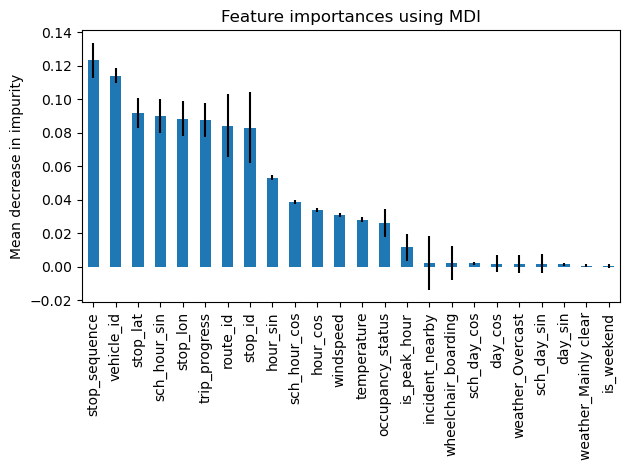

In [24]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

### Recursive Feature Elimination (RFE)

In [26]:
rfe_list = []
X_current = X.copy()
X_train_current = X_train.copy()
X_val_current = X_val.copy()
best_rmse = float('inf')
best_features = X_train_current.columns.tolist()
patience = 2 # allow 2 RMSE increases before stopping
patience_counter = 0 

keep_going = True

while keep_going and len(X_current.columns) > 5: # keep at least 5 features
	# Fit model
	rf = RandomForestRegressor(
		n_estimators=best_n,
		min_samples_split=best_params['min_samples_split'],
  		min_samples_leaf=best_params['min_samples_leaf'],
  		max_leaf_nodes=best_params['max_leaf_nodes'],
  		max_depth=best_params['max_depth'],
  		max_features=best_params['max_features'],
		random_state=42,
		n_jobs=-1
	)

	nb_features = len(X_current.columns)
	rf.fit(X_train_current, y_train)

	# Predict and calculate RMSE
	y_pred = rf.predict(X_val_current)
	rmse = root_mean_squared_error(y_val, y_pred)

	rfe = {
		'nb_features': nb_features,
		'rmse': rmse
	}

	# Feature importances
	importances = pd.Series(rf.feature_importances_, index=X_current.columns)
	weakest_feature = importances.idxmin()

	if rmse <= best_rmse:
		best_rmse = rmse
		best_features = X_current.columns.tolist()
		
		# Drop the weakest feature
		print(f'RMSE: {rmse:.4f} | Dropping: {weakest_feature} (importance {importances.min():.6f})')
		X_current = X_current.drop(columns=[weakest_feature], axis=1)
		X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
		X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)

		patience_counter = 0 # reset patience is RMSE improves
		rfe['worsened_point'] = False
		rfe_list.append(rfe)
	else:
		patience_counter += 1
		rfe['worsened_point'] = True
		rfe_list.append(rfe)
		print(f'Patience counter: {patience_counter}/{patience}')

		if patience_counter >= patience:
			print('Performance worsened too much. Stopping feature elimination.')
			keep_going = False
		else:
			# Allow two bad steps: still drop feature and continue
			X_current = X_current.drop(columns=[weakest_feature], axis=1)
			X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
			X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)


rfe_df = pd.DataFrame(rfe_list)
print('\nBest set of features found:')
print('\n'.join(best_features))
print(f'Final validation RMSE: {best_rmse:.4f}')

RMSE: 102.2895 | Dropping: is_weekend (importance 0.000462)
RMSE: 102.2920 | Dropping: weather_Mainly clear (importance 0.000831)
Performance worsened. Stopping feature elimination.

Best set of features found:
['vehicle_id', 'occupancy_status', 'route_id', 'stop_id', 'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress', 'wheelchair_boarding', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 'sch_hour_sin', 'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'temperature', 'windspeed', 'weather_Mainly clear', 'weather_Overcast', 'incident_nearby']
Final validation RMSE: 102.2895


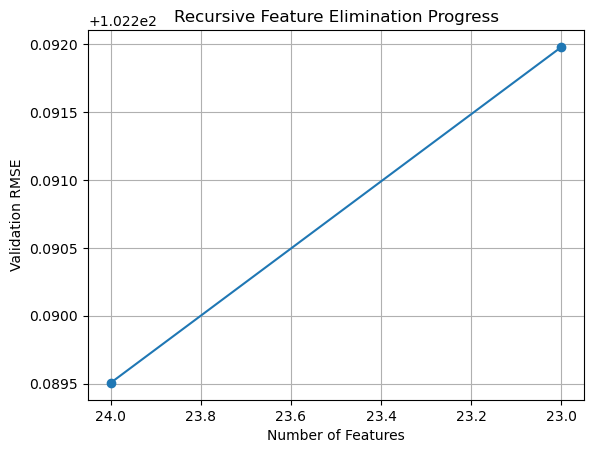

In [27]:
worsened_mask = rfe_df['worsened_point']

# Plot RSME at each step
plt.figure(figsize=(10,6))

# Good steps
plt.plot(
  rfe_df.loc[~worsened_mask, 'nb_features'],
  rfe_df.loc[~worsened_mask, 'rmse'],
  marker='o-',
  label='Improved or Same RMSE',
  color='blue')

# Worsened steps
plt.plot(
  rfe_df.loc[worsened_mask, 'nb_features'],
  rfe_df.loc[worsened_mask, 'rmse'],
  marker='X',
  label='Worsened RMSE',
  color='red')

plt.gca().invert_xaxis() # Highest number of features on the left
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.title('Recursive Feature Elimination Progress')
plt.legend()
plt.grid(True)
plt.savefig('../images/rfe_rf_tuned.png', bbox_inches='tight')
plt.show()

In [39]:
# Keep best features
X_best = X[best_features]
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]

In [41]:
# Retrain model on reduced features
rf_retrained = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_retrained.fit(X_train_best, y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=650, n_jobs=-1,
                      random_state=42)

In [42]:
# Evaluate model
y_pred = rf_retrained.predict(X_val_best)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_retrained', mae, rmse, r2]
metrics_df

MAE: 61.07
RMSE: 101.46
R²: 0.2294


### Retune Parameters

In [43]:
param_grid = {
	'n_estimators': list(range(100, 750, 50)),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  	estimator=RandomForestRegressor(random_state=42),
  	param_distributions=param_grid,
  	scoring='neg_root_mean_squared_error',
  	n_iter=10,
	cv=5,
  	n_jobs=-1,
  	random_state=42
)

random_model.fit(X_train_best, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'max_leaf_nodes': [None, 50, 100],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [300, 320, 340, 360,
                                                         380, 400, 420, 440,
                                                         460, 480, 500, 520,
                                                         540, 560, 580, 600,
                                                         620, 640, 660, 680,
                                                         700]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [44]:
# Fit model with best parameters
best_params = random_model.best_params_

rf_final = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_best, y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=380, n_jobs=-1,
                      random_state=42)

### Revalidate Model

In [45]:
# Evaluate model
y_pred = rf_final.predict(X_val_best)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_final', mae, rmse, r2]
metrics_df

MAE: 61.03
RMSE: 101.42
R²: 0.2299


Interpret results

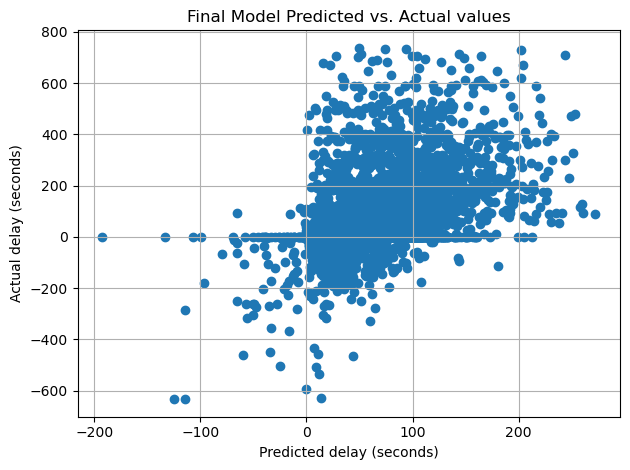

In [46]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Final Model Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/actual_vs_predict_rf_final.png', bbox_inches='tight')
plt.show()

Interpret plot

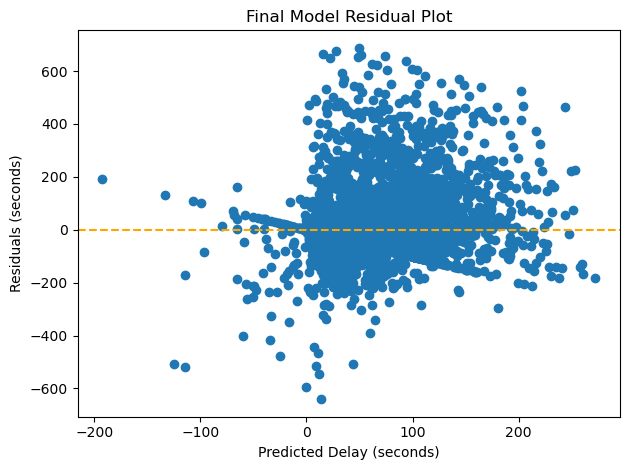

In [47]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Final Model Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_rf_final.png', bbox_inches='tight')
plt.show()

Interpret plot

In [52]:
# Save best parameters and features
rf_attributes = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_attributes.pkl', 'wb') as handle:
	pickle.dump(rf_attributes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# Save model
joblib.dump(rf_final, '../models/rf_model.pkl')

['../models/rf_model.pkl']

## Second Model: Random Forest + Gradient Boosting (Model ensembling)

## Third Model: XGBoost

## Final Model

### Evaluation

### Make Prediction

## End